In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
import pickle

%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15, 6

# import timeseries_nn

In [30]:
f = '../datastore/paystations/32489_61_days.d' 
key = 32489
data = pickle.load(open(f, 'rb'))
print np.shape(data)
train = data[0:12].flatten()
actual = data.flatten()



(61, 24)


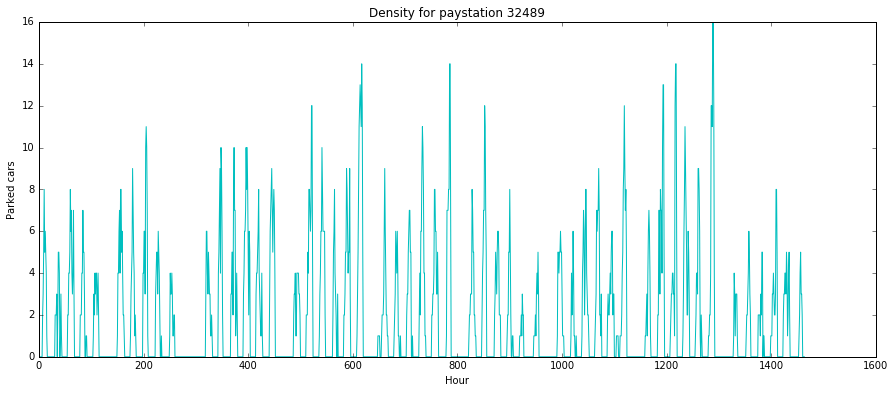

In [31]:
plt.plot(actual, color='c')
plt.ylabel('Parked cars')
plt.xlabel('Hour')
plt.title('Density for paystation %s' % key)
plt.show()

In [21]:
# Timeseries 
class ts_net(object):
	def __init__(self, hidden_layers = [20, 15, 5], activation_functions = ['relu', 'relu', 'relu'], 
              optimizer = SGD(), loss = 'mean_absolute_error'):
		self.hidden_layers = hidden_layers
		self.activation_functions = activation_functions
		self.optimizer = optimizer
		self.loss = loss

		if len(self.hidden_layers) != len(self.activation_functions):
			raise Exception("hidden_layers size must match activation_functions size")

	def fit(self, timeseries, lag = 7, epochs = 10000, verbose = 0):
		self.timeseries = np.array(timeseries, dtype = "float64") # Apply log transformation por variance stationarity
		self.lag = lag
		self.n = len(timeseries)
		if self.lag >= self.n:
			raise ValueError("Lag is higher than length of the timeseries")
		self.X = np.zeros((self.n - self.lag, self.lag), dtype = "float64")
		self.y = np.log(self.timeseries[self.lag:])
		self.epochs = epochs
		self.scaler = StandardScaler()
		self.verbose = verbose

		print "Building regressor matrix"
		# Building X matrix
		for i in range(0, self.n - lag):
			self.X[i, :] = self.timeseries[range(i, i + lag)]

		print "Scaling data"
		self.scaler.fit(self.X)
		self.X = self.scaler.transform(self.X)

		print "Checking network consistency"
		# Neural net architecture
		self.nn = Sequential()
		self.nn.add(Dense(self.hidden_layers[0], input_shape = (self.X.shape[1],)))
		self.nn.add(Activation(self.activation_functions[0]))

		for layer_size, activation_function in zip(self.hidden_layers[1:],self.activation_functions[1:]):
			self.nn.add(Dense(layer_size))
			self.nn.add(Activation(activation_function))

		# Add final node
		self.nn.add(Dense(1))
		self.nn.add(Activation('linear'))
		self.nn.compile(loss = self.loss, optimizer = self.optimizer)

		print "Training neural net"
		# Train neural net
		self.nn.fit(self.X, self.y, nb_epoch = self.epochs, verbose = self.verbose)

	def predict_ahead(self, n_ahead = 1):
		# Store predictions and predict iteratively
		self.predictions = np.zeros(n_ahead)

		for i in range(n_ahead):
			self.current_x = self.timeseries[-self.lag:]
			self.current_x = self.current_x.reshape((1, self.lag))
			self.current_x = self.scaler.transform(self.current_x)
			self.next_pred = self.nn.predict(self.current_x)
			self.predictions[i] = np.exp(self.next_pred[0, 0])
			self.timeseries = np.concatenate((self.timeseries, np.exp(self.next_pred[0,:])), axis = 0)

		return self.predictions


In [25]:
# Create Net
neural_net = ts_net(hidden_layers = [20, 15, 5], 
    activation_functions = ['sigmoid', 'sigmoid', 'sigmoid'])


In [28]:
# Train Net
neural_net.fit(train, lag = 10, epochs = 10000)


Building regressor matrix
Scaling data
Checking network consistency
Training neural net


In [29]:
neural_net.predict_ahead(n_ahead = 200)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

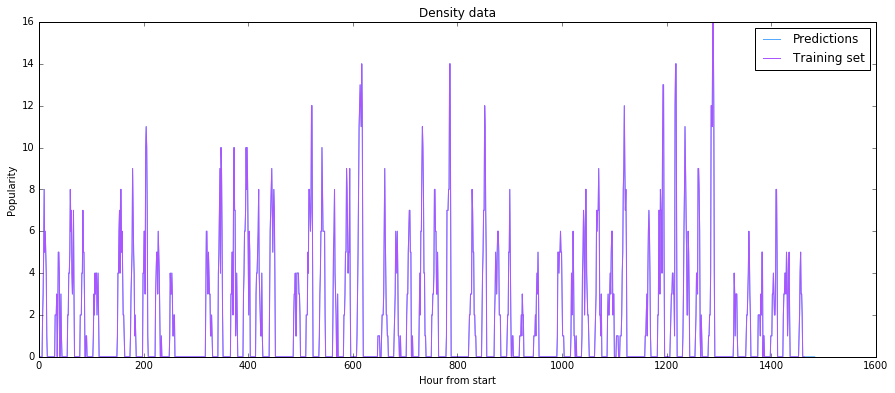

In [14]:
import matplotlib.cm as cm
clr = np.linspace(0, 1, 4)
plt.plot(range(len(neural_net.timeseries)), neural_net.timeseries, color=cm.cool(clr[1]), label='Predictions', linewidth=1)
plt.plot(range(len(train)), train, '-', color=cm.cool(clr[2]), label='Training set')
# plt.plot(range(len(actual)), actual, '--', color=cm.cool(clr[3]), label='Original set')

plt.title("Density data")
plt.xlabel("Hour from start")
plt.ylabel("Popularity")
plt.legend()
plt.show()